# Contents
1. Import Libraries and Data<br>
    1.1. Libraries <br>
    1.2. Formatting Data and Concatenating DataFrames <br>
    
    
2. Cleaning and Pre-Processing <br> 
    
    
3. EDA <br>
    3.1. Categorical Data (Visual + Statistical) <br>
    3.2. Numerical Data <br>
    
    
4. Models <br>
    4.1. Goals Prediction via xG vs All Features (Linear Regression) <br>
    4.2. XGB Regressor Optimization <br>
    4.3. Conclusion

# 1. Importing Libraries and Data

## 1.1. Libraries

In [128]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind, chi2_contingency
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import pingouin as pg
from scipy.stats import pearsonr
%matplotlib inline 

## 1.2. Formatting Data and Concatenating DataFrames

The data is currently presented with a multi-level index, which can make it challenging to create graphs. Therefore, we will flatten the data. This process will be performed on six separate CSV files, each representing a single season between 2017 and 2022.

Below is an example of the multi-level index for the 2022 season:

In [129]:
df_example = pd.read_csv('df_2022_player.csv', header = [0, 1])
df_example.head(1)

level_0              index              league  \
  Unnamed: 0_level_1 Unnamed: 1_level_1  Unnamed: 2_level_1   
0                  0                  0  ENG-Premier League   

              season                               game               team  \
  Unnamed: 3_level_1                 Unnamed: 4_level_1 Unnamed: 5_level_1   
0               2223  2022-08-05 Crystal Palace-Arsenal            Arsenal   

              player                  #             Nation                Pos  \
  Unnamed: 6_level_1 Unnamed: 7_level_1 Unnamed: 8_level_1 Unnamed: 9_level_1   
0     Aaron Ramsdale                1.0            eng ENG                 GK   

                  Age                 Min Performance                      \
  Unnamed: 10_level_1 Unnamed: 11_level_1         Gls Ast PK PKatt Sh SoT   
0              24-083                  90           0   0  0     0  0   0   

                                   Expected           SCA     Passes      \
  CrdY CrdR Touches Tkl Int Blocks       xG npxG  xAG SCA GCA    Cmp Att   
0    0    0      33   0   0      0      0.0  0.0  0.0   0   0     24  32   

             Carries      Take-Ons                  game_id  
   Cmp% PrgP Carries PrgC      Att Succ Unnamed: 37_level_1  
0  75.0    0      24    0        0    0            e62f6e78

In [130]:
# Create seperate dataframes for each level of index (years 2017-2022)
for year in range(2017, 2023):
    df = pd.read_csv(f'df_{year}_player.csv', header=[0])
    df_a = pd.read_csv(f'df_{year}_player.csv', header=[1])
    vars()[f'df_{year}'] = df
    vars()[f'df_{year}a'] = df_a 
    
# Store seperate dataframes in respective lists
df_list = [df_2022a, df_2021a, df_2020a, df_2019a, df_2018a, df_2017a]
df_ref_list = [df_2022, df_2021, df_2020, df_2019, df_2018, df_2017]

# Function that combines above dataframe column names
def single_level(dfa, df):
    lst = dfa.columns.to_list()
    indices = [i for i, x in enumerate(lst) if x.startswith("Unnamed")]
    replace_lst = df.columns[indices]
    for i in indices:
        lst[i] = replace_lst[indices.index(i)]
    dfa.rename(columns=dict(zip(dfa.columns, lst)), inplace=True)

# Apply function while iterating over each pair of dataframes from years 2017-2022
for i, df_a in enumerate(df_list):
    single_level(df_a, df_ref_list[i])
    
# Concatenate the list of dataframes into one large dataframe and drop unnecessary columns   
def concatenate_dataframes(df_list_to_concatenate):
    df_concatenated = pd.concat(df_list_to_concatenate).drop(['level_0', 'index'], axis=1).reset_index(drop=True)
    return df_concatenated     
df = concatenate_dataframes(df_list)

df.sample(3)

,league,season,game,team,player,#,Nation,Pos,Age,Min,Gls,Ast,PK,PKatt,Sh,SoT,CrdY,CrdR,Touches,Tkl,Int,Blocks,xG,npxG,xAG,SCA,GCA,Cmp,Att,Cmp%,PrgP,Carries,PrgC,Att.1,Succ,game_id,Prog
7573,ENG-Premier League,2122,2021-08-22 Arsenal-Chelsea,Chelsea,Kai Havertz,29.0,de GER,AM,22-072,89.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,55.0,0.0,0.0,1.0,0.7,0.7,0.0,8.0,0.0,39.0,44.0,88.6,8.0,38.0,5.0,4.0,1.0,93954213,NaN
16959,ENG-Premier League,2122,2022-05-12 Tottenham-Arsenal,Arsenal,Eddie Nketiah,30.0,eng ENG,FW,22-347,72.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,18.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0,8.0,9.0,88.9,1.0,13.0,1.0,3.0,0.0,607d0562,NaN
18432,ENG-Premier League,2021,2020-10-03 Leeds United-Manchester City,Manchester City,Benjamin Mendy,22.0,fr FRA,LB,26-078,70.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,31.0,54.8,NaN,NaN,NaN,2.0,2.0,5ce15b58,1.0


After flattening the multi-level index, we have transformed the data into a one-level column and successfully concatenated multiple seasons together.

# Cleaning and Pre-Processing

To maintain brevity, the cleaning and pre-processing steps have been condensed without extensive explanation below. Please refer to the provided dataframe sample above for a clearer understanding of the reasons behind each step.

In [131]:
def preprocess_data(df):
    # create date column from game column. Sort df by date
    df['date'] = pd.to_datetime(df['game'].apply(lambda x: x.split(" ", 1)[0]))
    df.sort_values(by='date', ascending=True, inplace = True)
    
    # rename values in team column to match team names in game column
    df['team'] = df['team'].replace({'Wolverhampton Wanderers':'Wolves', 'Newcastle United':'Newcastle Utd', 'Tottenham Hotspur':'Tottenham', 'Brighton & Hove Albion':'Brighton', 'Manchester United':'Manchester Utd', 'West Ham United':'West Ham', 'Nottingham Forest':"Nott'ham Forest", "Sheffield United": "Sheffield Utd", "West Bromwich Albion": "West Brom", "Huddersfield Town":"Huddersfield"})

    # define home/away games
    df['home_team'] = df['game'].apply(lambda x: x.split(" ", 1)[1].split("-", 1)[0])
    df['away_team'] = df['game'].apply(lambda x: x.split(" ", 1)[1].split("-", 1)[1]) 
    df['Location'] = df.apply(lambda row: 'Home' if row['team'] == row['home_team'] else 'Away', axis=1)
        
    # add hyphen to values in season
    for i, season in enumerate(df['season']):
        season_str = str(season)
        new_season_str = '-'.join([season_str[j:j+2] for j in range(0, len(season_str), 2)])
        df.at[i, 'season'] = new_season_str
        
    # remove days from age and convert to float 
    df['Age'] = df['Age'].astype(str).apply(lambda x: x.split("-", 1)[0]).astype(float)
    
    # clean up positions and bin them
    df['Pos'] = df['Pos'].astype(str).apply(lambda x: x.split(",", 1)[0]).replace({'DF': np.nan, 'MF': np.nan, 'nan': np.nan}).dropna()
    position_map = {
        'Goalkeeper': ['GK'],
        'Center Back': ['CB'],
        'Fullbacks': ['LB', 'RB', 'WB'],
        'Defensive Midfield': ['DM'],
        'Central Midfield': ['CM'],
        'Attacking Midfield': ['AM'],
        'Wide Midfield': ['LM', 'RM'],
        'Wide Attacker': ['LW', 'RW'],
        'Forward': ['FW']}
    for position, positions in position_map.items():
        df.loc[df['Pos'].isin(positions), 'Pos'] = position
    
    # clean up nations and bin them 
    df['Continent'] = df['Nation'].astype(str).apply(lambda x: x.split(" ", 1)[1] if " " in x else x).replace({'nan': np.nan})
    continent_map = {
    'Europe': ['ENG', 'WAL', 'POR', 'GER', 'ESP', 'UKR', 'FRA', 'SUI', 'DEN', 'SWE', 'NED', 'SCO', 'IRL', 'BEL', 'POL', 'NOR', 'AUT', 'ITA', 'SRB', 'CRO', 'GRE', 'NIR', 'ALB', 'BIH', 'FIN', 'KVX', 'ISL', 'MKD', 'SVN', 'ROU', 'EST', 'CZE', 'SVK', 'TUR'],
    'Africa': ['ARG', 'MAR', 'GAB', 'SEN', 'CMR', 'NGA', 'MLI', 'ZIM', 'CIV', 'BFA', 'GHA', 'DRC', 'MR', 'AO', 'TZ', 'KE', 'TG', 'BJ', 'GQ', 'BI', 'SL', 'ZAM', 'KEN', 'TOG', 'BDI', 'SLE', 'MTN', 'EQG', 'ANG', 'ALG', 'TUN', 'GUI', 'EGY', 'COD', 'RSA', 'TAN', 'BEN'],
    'South America': ['BRA', 'ARG', 'VEN', 'PAR', 'URU', 'PER', 'COL', 'ECU'],
    'North America': ['USA', 'CRC', 'CAN', 'CUW', 'GRN', 'MEX', 'SKN', 'CUB', 'BER', 'JAM'],
    'Asia': ['KOR', 'ISR', 'JPN', 'IRN', 'CHI', 'ARM', 'PHI'],
    'Oceania': ['AUS', 'NZL']}
    for continent, countries in continent_map.items():
        df.loc[df['Continent'].isin(countries), 'Continent'] = continent
        
    # make red cards and yellow cards categories as opposed to floats
    df['CrdR'] = df['CrdR'].astype('category')
    df['CrdY'] = df['CrdY'].astype('category')
    
    # drop columns
    df.drop(['home_team', 'away_team', '#', 'game', 'league', 'Nation', 'Prog', 'game_id'], axis = 1, inplace = True)
    
    # handle nan
    df.dropna(subset = ['Pos', 'Min', 'Continent', 'Att.1'], inplace = True)
    df.fillna(df.mean(), inplace=True)
    df.reset_index(inplace = True, drop = True)
    
preprocess_data(df)

# 3. EDA

Our objective is to identify input features that have a significant impact on our target variable, Goals. 

## 3.1. Categorical Data 

### Visual

In [132]:
categ_columns = ['Location', 'CrdR', 'CrdY', 'Pos', 'Continent']

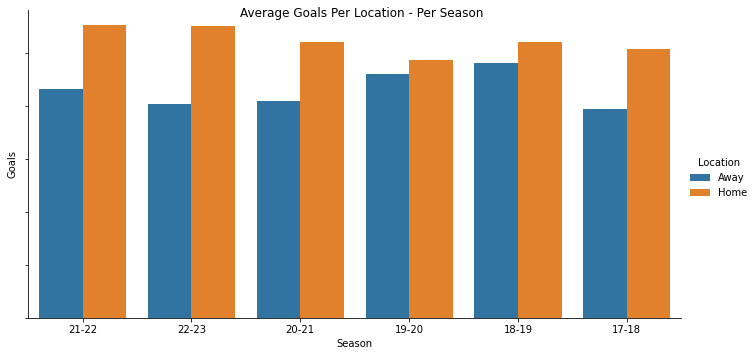

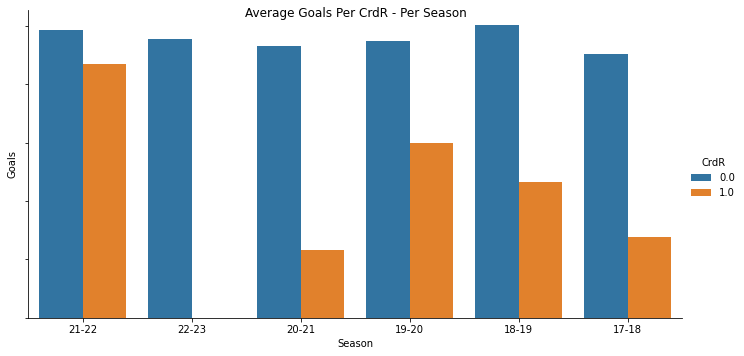

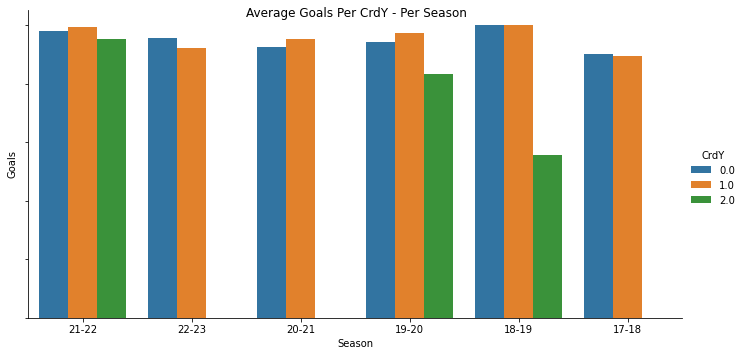

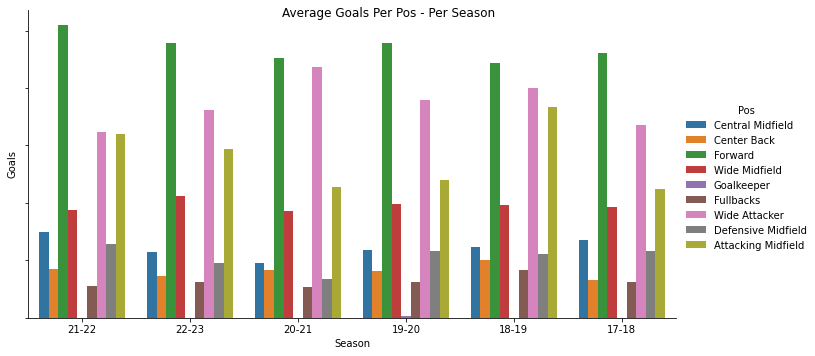

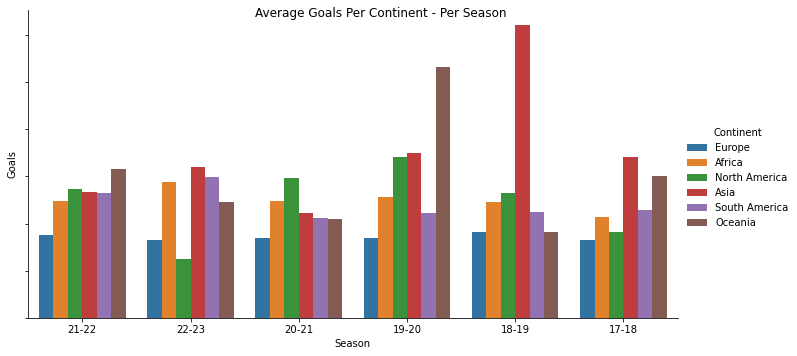

In [133]:
def plot_cat_season(df, hue_col, title):
    g = sns.catplot(x='season', y='Gls', hue=categ, data=df, kind='bar', height=5, aspect=2, ci=None)
    g.fig.suptitle(title)
    g.set(yticklabels=[])
    plt.xlabel('Season')
    plt.ylabel('Goals')
    plt.show()

for categ in categ_columns:
    plot_cat_season(df, categ, title = f'Average Goals Per {categ} - Per Season')

Location: Clear difference between Home/Away games <br>

Red Cards (CrdR): Clear difference between with/without red card <br> 

Yellow Cards (CrdY): No discernible difference between games where no yellow cards were issued and games where one yellow card was issued. Two yellow cards result in a red card and were thus included in the CrdR analysis. <br> 

Pos: Clear differences between positions <br> 

Continent: Less clear but differences between continents potentially exist 

## Statistical

We confirm our interpretation of the visual graphs above by conducting statistical tests.

### Two-Sample T-test for Goals vs Location/Red Cards (CrdR)

In [134]:
t_stat, p_val = ttest_ind(df[df['Location'] == 'Home']['Gls'], df[df['Location'] == 'Away']['Gls'], equal_var=True)
print('Location: P-value -', p_val)

t_stat, p_val = ttest_ind(df[df['CrdR'] == 0]['Gls'], df[df['CrdR'] == 1]['Gls'], equal_var=True)
print('CrdR: P-value -', p_val)

Location: P-value - 2.9883125580791676e-11
CrdR: P-value - 0.019386768913327936


Both the location variable and the variable indicating whether a red card was issued or not show statistically significant differences in mean goals, with p-values < 0.05. These results, in conjunction with our interpretation of the graphs above, make it worthwhile to include them in the model.

### ANOVA for Goals vs  Position (Pos)/Continent/Yellow Cards

In [135]:
categ_multi_test = ['Pos', 'Continent', 'CrdY']
for x in categ_multi_test:
    formula = f'Gls ~ C({x})'
    model = ols(formula, data = df).fit()
    print(f'P-Value for {x}: ' + str(sm.stats.anova_lm(model, typ = 2)['PR(>F)'].values[0]))

P-Value for Pos: 0.0
P-Value for Continent: 3.509163249194074e-35
P-Value for CrdY: 0.4100729290840395


Our analysis reveals that when controlling for categories within Continent, Position, and CrdY, there is a statistically significant difference in mean Goals at a significance level of p < 0.05 for Continent and Position. This finding suggests that it may be worth including these variables in our model. However, we need to investigate further to identify which categories within each variable produce statistically different means from one another.

As the equivalence of variance assumption for the Tukey test is violated, we will instead use the Games-Howell test to find which categories within variables Continent and Position are statistically different. The Games-Howell test is more appropriate when variances are unequal.

Based on our analysis, we did not observe a statistically significant difference in the average number of goals scored in games with and without yellow cards, as indicated by a p-value of 0.4101. Therefore, we can omit the variable "CrdY" from our model, especially given the unclear visual graph.

### Games-Howell for Goals vs Position (Pos)/Continent

In [136]:
categ_multi_test = ['Pos', 'Continent']
for x in categ_multi_test:
    df_table = pd.DataFrame(pg.pairwise_gameshowell(data=df, dv='Gls', between=x))
    df_table_1 = df_table[['B', 'A', 'mean(A)', 'mean(B)', 'diff', 'se', 'T', 'df', 'pval', 'hedges']].rename(columns={'B':'A', 'A':'B'})
    df_table_concat = pd.concat([df_table, df_table_1]).rename(columns = {'A': f'{x}'}).sort_values(by = f'{x}').reset_index(drop = True)
    df_table_concat['reject'] = np.where(df_table_concat['pval'] < 0.05, False, True)
    (df_table_concat.groupby(f'{x}')['reject'].mean() * 100).to_frame().rename(columns = {'reject': '% of P-value > .05'}).sort_values(by = '% of P-value > .05', ascending = False)

,% of P-value > .05
Pos,
Defensive Midfield,25.0
Center Back,12.5
Central Midfield,12.5
Attacking Midfield,0.0
Forward,0.0
Fullbacks,0.0
Goalkeeper,0.0
Wide Attacker,0.0
Wide Midfield,0.0


,% of P-value > .05
Continent,
Africa,80.0
North America,80.0
Oceania,80.0
Asia,60.0
South America,60.0
Europe,0.0


For the variable "Continent", most categories have p-values greater than 0.05, except for Europe, indicating that a statistically significant difference in mean Goals is only observed for European players. Therefore, it should be worth including a feature for European players in the model. Other categories could potentially be combined into an "other" category, as their impact is unclear. <br> <br>
Regarding the variable "Pos", most categories have p-values less than 0.05, indicating that a statistically significant difference in mean Goals is observed between most categories. Therefore, it would be worth including the Position variable in the model.

# 3.2. Numerical Data

In [137]:
float_cols = df.select_dtypes(include=['float'])

## Correlation Matrix

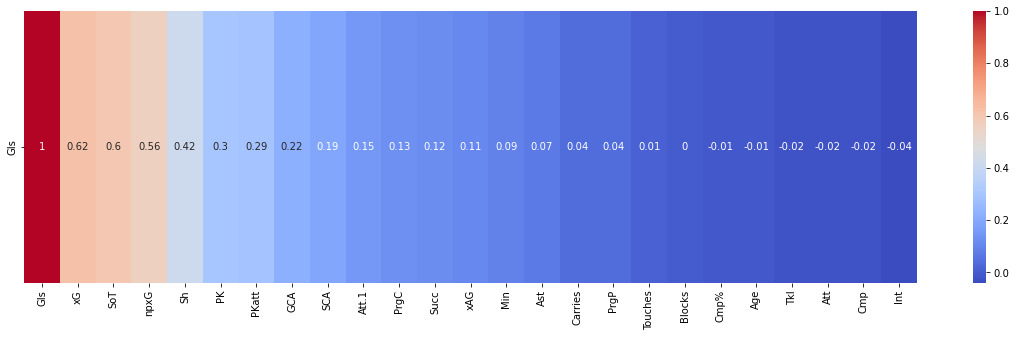

In [138]:
corr_matrix = float_cols.corr().iloc[2:3, :].sort_values(by='Gls', ascending=False, axis=1).round(2)

plt.figure(figsize=(20, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show();

We can observe some clear multicollinearity in the data, as shown by the strong correlation between certain variables, such as Shots on Target and Shots, or Penalty Kicks Scored and Penalty Kicks Attempted. However, since the purpose of this project is to build a predictive model, multicollinearity is not a major concern. If we were focused on interpretability, we would need to formally address this issue.

Although some attributes have low correlation coefficients, they may still be useful in the model. To investigate this, we can visualize their relationship with the target variable using scatter plots.

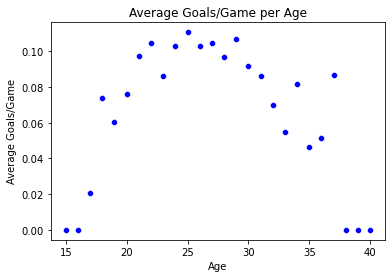

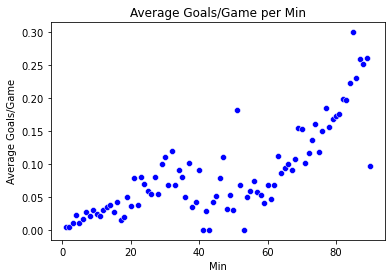

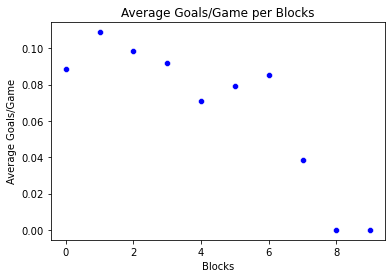

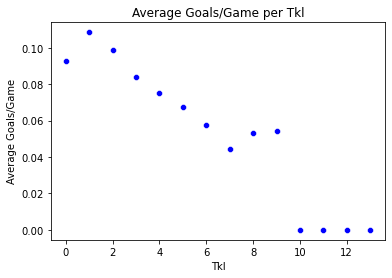

In [139]:
scatter_list = ['Age', 'Min', 'Blocks', 'Tkl']
for x in scatter_list:
    # calculate the average goals per age
    avg_goals_per_age = df.groupby(x)['Gls'].mean().reset_index()

    # plot the scatter graph
    _ = sns.scatterplot(data=avg_goals_per_age, x=x, y='Gls', color='blue')
    _ = plt.title(f'Average Goals/Game per {x}')
    _ = plt.xlabel(x)
    _ = plt.ylabel('Average Goals/Game')
    plt.show(); 

Age: There seems to be a clear second-order relationship, with the highest number of goals scored between the ages of 23 and 30, and a drop-off on either side. <br>
Min: There is a significant linear relationship after the 60-minute mark, which is more pronounced and clear. However, before that, although there is a positive linear relationship, it is less steep and more obscured by noise. <br>
Blocks/Tkl: A clear negative relationship. <br>

Even though all these variables appear to be significant for our model, we may want to consider binning the categories within the 'Age' and 'Min' variables to potentially improve their predictive power.

# 4. Models

We will be creating two linear regression models to predict the number of goals scored in a match. One model will use only xG as a predictor, while the other model will use all available features. We will compare the performance of these two models to see if the additional features improve the accuracy of our predictions.

Additionally, we will perform hyper-parameter optimization of an XGB regressor model using nested cross-validation and RandomSearch. The aim is to compare the performance of this optimized model with that of a simple linear regression model.

Creating the model dataframe

In [140]:
# Categorical Columns
df_encoded = pd.get_dummies(df, columns=categ_columns)
df_encoded_cols = [col for col in df_encoded.columns if '_' in col]
df_encoded = df_encoded.filter(df_encoded_cols)

# Numerical Columns 
df_numerical = df.select_dtypes(include=['float'])

# Combine 
df_model = pd.concat([df_encoded, df_numerical], axis = 1)

## 4.1. Goals Prediction via xG vs All Features (Linear Regression)

In [141]:
# Create an empty list to store fold results
fold_results_r2_xG = []
fold_results_rmse_xG = []
fold_results_r2_all = []
fold_results_rmse_all = []

# Use TimeSeriesSplit to split into training and test sets based on date
tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_index, test_index) in enumerate(tscv.split(df_model), 1):

    # Split into input and target variables for xG and Gls
    x_xG = df_model['xG'].iloc[train_index]
    y_Gls = df_model['Gls'].iloc[train_index]
    x_xG_test = df_model['xG'].iloc[test_index]
    y_Gls_test = df_model['Gls'].iloc[test_index]

    # Split into input and target variables for all features
    x_all = df_model.drop('Gls', axis=1).iloc[train_index]
    y_all = df_model['Gls'].iloc[train_index]
    x_all_test = df_model.drop('Gls', axis=1).iloc[test_index]
    y_all_test = df_model['Gls'].iloc[test_index]

    # Create a Linear Regression object for xG and Gls
    linear_reg_xG = LinearRegression()

    # Reshape
    x_xG_reshaped = np.array(x_xG).reshape(-1, 1)
    y_Gls_reshaped = np.array(y_Gls).reshape(-1, 1)
    x_xG_test_reshaped = np.array(x_xG_test).reshape(-1, 1)
    y_Gls_test_reshaped = np.array(y_Gls_test).reshape(-1, 1)

    # Train the model on the training data
    lin_model_xG = linear_reg_xG.fit(x_xG_reshaped, y_Gls_reshaped)

    # Evaluate the performance of the model on the test data for xG and Gls
    y_pred_xG = lin_model_xG.predict(x_xG_test_reshaped)
    r2_xG = r2_score(y_Gls_test_reshaped, y_pred_xG)
    rmse_xG = mean_squared_error(y_Gls_test_reshaped, y_pred_xG, squared=False)
    print(f"Fold {fold} (xG): R-squared score: {r2_xG:.4f}, RMSE: {rmse_xG:.4f}")
    fold_results_r2_xG.append(r2_xG)
    fold_results_rmse_xG.append(rmse_xG)

    # Create a Linear Regression object for all features
    linear_reg_all = LinearRegression()

    # Train the model on the training data
    lin_model_all = linear_reg_all.fit(x_all, y_all)

    # Evaluate the performance of the model on the test data for all features except Gls
    y_pred_all = lin_model_all.predict(x_all_test)
    r2_all = r2_score(y_all_test, y_pred_all)
    rmse_all = mean_squared_error(y_all_test, y_pred_all, squared=False)
    print(f"Fold {fold} (all features): R-squared score: {r2_all:.4f}, RMSE: {rmse_all:.4f}")
    fold_results_r2_all.append(r2_all)
    fold_results_rmse_all.append(rmse_all)
    
    print("----------------------------------------------------------------------")

# Calculate the mean and standard deviation of the fold results for just xG
mean_r2 = np.mean(fold_results_r2_xG)
std_r2 = np.std(fold_results_r2_xG)
mean_rmse = np.mean(fold_results_rmse_xG)
std_rmse = np.std(fold_results_rmse_xG)
print(f"Mean R-squared score for xG: {mean_r2:.4f} +/- {std_r2:.4f}")
print(f"Mean RMSE for xG: {mean_rmse:.4f} +/- {std_rmse:.4f}")
print("----------------------------------------------------------------------")

# Calculate the mean and standard deviation of the fold results for all inputs
mean_r2 = np.mean(fold_results_r2_all)
std_r2 = np.std(fold_results_r2_all)
mean_rmse = np.mean(fold_results_rmse_all)
std_rmse = np.std(fold_results_rmse_all)
print(f"Mean R-squared score for all features: {mean_r2:.4f} +/- {std_r2:.4f}")
print(f"Mean RMSE for all inputs: {mean_rmse:.4f} +/- {std_rmse:.4f}")
print("----------------------------------------------------------------------")

# Split the data into training and testing sets
train_df, test_df = train_test_split(df_model, test_size=0.2, shuffle=False)

# Define the different scenarios to test
scenarios = [{'x_col': 'xG', 'drop_col': False}, {'x_col': None, 'drop_col': True}]
scenario_names = ['xG Model', 'All Features Model']

# Loop through each scenario
for i, scenario in enumerate(scenarios):
    # If the scenario involves dropping a column, drop it from the training and testing sets
    if scenario['drop_col']:
        x_train = train_df.drop('Gls', axis=1)
        x_test = test_df.drop('Gls', axis=1)
    # If the scenario involves using only one column, select it from the training and testing sets
    else:
        x_train = train_df[scenario['x_col']].to_numpy().reshape(-1, 1)
        x_test = test_df[scenario['x_col']].to_numpy().reshape(-1, 1)

    # Define the target variable for both the training and testing sets
    y_train = train_df['Gls'].to_numpy()
    y_test = test_df['Gls'].to_numpy()

    # Train a linear regression model on the training data
    linear_reg = LinearRegression()
    lin_model = linear_reg.fit(x_train, y_train)

    # Use the trained model to make predictions on the testing data
    y_pred = lin_model.predict(x_test)

    # Calculate the Pearson correlation coefficient between the predicted and actual values
    corr_coef = pearsonr(y_pred, y_test)
    
    # Print the correlation coefficient for the current scenario

    print(f"Pearson correlation coefficient for {scenario_names[i]}: {corr_coef[0]:.4f}")

Fold 1 (xG): R-squared score: 0.3862, RMSE: 0.2641
Fold 1 (all features): R-squared score: 0.5022, RMSE: 0.2378
----------------------------------------------------------------------
Fold 2 (xG): R-squared score: 0.3567, RMSE: 0.2629
Fold 2 (all features): R-squared score: 0.4796, RMSE: 0.2365
----------------------------------------------------------------------
Fold 3 (xG): R-squared score: 0.3862, RMSE: 0.2565
Fold 3 (all features): R-squared score: 0.5031, RMSE: 0.2308
----------------------------------------------------------------------
Fold 4 (xG): R-squared score: 0.3888, RMSE: 0.2596
Fold 4 (all features): R-squared score: 0.5206, RMSE: 0.2299
----------------------------------------------------------------------
Fold 5 (xG): R-squared score: 0.3818, RMSE: 0.2544
Fold 5 (all features): R-squared score: 0.5039, RMSE: 0.2279
----------------------------------------------------------------------
Mean R-squared score for xG: 0.3799 +/- 0.0118
Mean RMSE for xG: 0.2595 +/- 0.0037
--

### Summary

The model that includes all the inputs has shown better performance compared to the xG alone model in terms of higher R-squared value (0.5019 vs 0.3799), lower RMSE (0.2326 vs 0.2595) and higher correlation coefficient (0.7120 vs 0.6233). Based on these results, we can reasonably conclude that these additional features, when used in combination with xG, have the potential to improve the accuracy of future goal predictions beyond what xG alone can achieve.

## 4.2. XGB Regressor Optimization

### Before Optimization

In [142]:
# Split into input and target variables
x = df_model.drop('Gls', axis = 1)
y = df['Gls']

# Create an empty list to store fold results
fold_results_r2 = []
fold_results_rmse = []

# Use TimeSeriesSplit to split into training and test sets based on date
tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_index, test_index) in enumerate(tscv.split(df), 1):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create a XGB Regression object
    linear_reg = xgb.XGBRegressor()

    # Train the model on the training data
    lin_model = linear_reg.fit(x_train, y_train)

    # Evaluate the performance of the model on the test data
    y_pred = lin_model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Fold {fold}: R-squared score: {r2:.4f}, RMSE: {rmse:.4f}")
    fold_results_r2.append(r2)
    fold_results_rmse.append(rmse)
    
# Calculate the mean and standard deviation of the fold results
mean_r2 = np.mean(fold_results_r2)
std_r2 = np.std(fold_results_r2)
mean_rmse = np.mean(fold_results_rmse)
std_rmse = np.std(fold_results_rmse)
print(f"Mean R-squared score: {mean_r2:.4f} +/- {std_r2:.4f}")
print(f"Mean RMSE: {mean_rmse:.4f} +/- {std_rmse:.4f}")

# Split the data into training and testing sets
train_df, test_df = train_test_split(df_model, test_size=0.2, shuffle=False)

# Define target and input variables for training and testing sets
x_train = train_df.drop('Gls', axis = 1)
y_train = train_df['Gls'].to_numpy()
x_test = test_df.drop('Gls', axis = 1)
y_test = test_df['Gls'].to_numpy()

# Create a XGB regression object and fit it to the training data
linear_reg = xgb.XGBRegressor()
lin_model = linear_reg.fit(x_train, y_train)

# Use the trained model to make predictions on the testing set
y_pred = lin_model.predict(x_test)

# Calculate the Pearson correlation coefficient between the predicted and actual values of the target variable
p = (pearsonr(y_pred, y_test))[0]
print(f"Pearson correlation coefficient: {p}")

Fold 1: R-squared score: 0.4395, RMSE: 0.2524
Fold 2: R-squared score: 0.4280, RMSE: 0.2479
Fold 3: R-squared score: 0.4656, RMSE: 0.2393
Fold 4: R-squared score: 0.5097, RMSE: 0.2325
Fold 5: R-squared score: 0.5072, RMSE: 0.2271
Mean R-squared score: 0.4700 +/- 0.0337
Mean RMSE: 0.2398 +/- 0.0094
Pearson correlation coefficient: 0.7056243587142234


### Optimization via Random Search

In [146]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df_model, test_size=0.2, shuffle=False)

# Define target and input variables for training and testing sets
x_train = train_df.drop('Gls', axis = 1)
y_train = train_df['Gls']

# Parameters to optimize
params = {
    'learning_rate' : [.05,.1,.15, .2, .25, .3],
    'max_depth' : range(3, 10, 1),
    'min_child_weight' : [1, 3, 5],
    'gamma' : [0, 1, 2, 3],
    'colsample_bytree' : [0.5, 0.7, 0.9]
}

# Define the RandomSearch object
random_search = RandomizedSearchCV(linear_reg, param_distributions=params, cv=tscv, n_iter=10, n_jobs=-1)

# Fit the RandomSearch object on the training data
_ = random_search.fit(x_train, y_train)

# Store the best parameters and best model as variables
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Print the best parameters
print(f"Best parameters: {best_params}")

Best parameters: {'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 2, 'colsample_bytree': 0.7}


### After Optimization

In [148]:
# Split into input and target variables
x = df_model.drop('Gls', axis = 1)
y = df_model['Gls']

# Create an empty list to store fold results
fold_results_r2 = []
fold_results_rmse = []

# Use TimeSeriesSplit to split into training and test sets based on date
tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_index, test_index) in enumerate(tscv.split(df), 1):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model with optimized hyper-parameters on the training data
    lin_model = best_model.fit(x_train, y_train)

    # Evaluate the performance of the model on the test data
    y_pred = lin_model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Fold {fold}: R-squared score: {r2:.4f}, RMSE: {rmse:.4f}")
    fold_results_r2.append(r2)
    fold_results_rmse.append(rmse)
    
# Calculate the mean and standard deviation of the fold results
mean_r2 = np.mean(fold_results_r2)
std_r2 = np.std(fold_results_r2)
mean_rmse = np.mean(fold_results_rmse)
std_rmse = np.std(fold_results_rmse)
print(f"Mean R-squared score: {mean_r2:.4f} +/- {std_r2:.4f}")
print(f"Mean RMSE: {mean_rmse:.4f} +/- {std_rmse:.4f}")

# Split the data into training and testing sets
train_df, test_df = train_test_split(df_model, test_size=0.2, shuffle=False)

# Define target and input variables for training and testing sets
x_train = train_df.drop('Gls', axis = 1)
y_train = train_df['Gls'].to_numpy()
x_test = test_df.drop('Gls', axis = 1)
y_test = test_df['Gls'].to_numpy()

# Fit model with optimized hyper-parameters on the training data
lin_model = best_model.fit(x_train, y_train)

# Use the trained model to make predictions on the testing set
y_pred = lin_model.predict(x_test)

# Calculate the Pearson correlation coefficient between the predicted and actual values of the target variable
p = (pearsonr(y_pred, y_test))[0]
print(f"Pearson correlation coefficient: {p}")
print("----------------------------------------------------------------------")

Fold 1: R-squared score: 0.5056, RMSE: 0.2370
Fold 2: R-squared score: 0.4952, RMSE: 0.2329
Fold 3: R-squared score: 0.5179, RMSE: 0.2273
Fold 4: R-squared score: 0.5415, RMSE: 0.2248
Fold 5: R-squared score: 0.5270, RMSE: 0.2225
Mean R-squared score: 0.5174 +/- 0.0162
Mean RMSE: 0.2289 +/- 0.0053
Pearson correlation coefficient: 0.728322322418983
----------------------------------------------------------------------


### Summary

Before XGB Regressor Optimization <br>
Mean R-squared: 0.4752 +/- 0.0336 <br>
Mean RMSE: 0.2386 +/- 0.0091 <br>
Pearson correlation coefficient: 0.7112663768296644 <br> <br>

Linear Regressor Optimization <br>
Mean R-squared score: 0.5019 +/- 0.0131 <br>
Mean RMSE: 0.2326 +/- 0.0039 <br>
Pearson correlation coefficient: 0.7121<br> <br>

After XGB Regressor Optimization <br>
Mean R-squared score: 0.5174 +/- 0.0162 <br>
Mean RMSE: 0.2289 +/- 0.0053 <br>
Pearson correlation coefficient: 0.728322322418983 <br> 

Our XGB Regressor model has shown notably better performance in comparison to the unoptimized XGB Regressor model and the linear model after applying optimization techniques.

## 4.3. Conclusion

The model that includes all the inputs outperforms the xG alone model in terms of R-squared, RMSE, and correlation coefficient. Furthermore, our optimized XGB Regressor model outperforms the unoptimized XGB Regressor and linear models. Overall, these findings suggest that incorporating additional features and using a more complex model than linear regression can lead to more accurate predictions of future goals.

###  Next Steps - Feature Engineering
- Team Stats - capture more information about chances each team's creating
- Time of Year 
- Recent performance/form for each player/team in offense/defense
- Travel time for away games 
- Game congestion impact

Check impact of inputs above on model performance